# Get my Birdie



In [74]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory


In [75]:
train_dir = './Birds_Species_Dataset/train'
validation_dir = './Birds_Species_Dataset/valid'
BATCH_SIZE = 64
IMG_SIZE = (224, 224)

In [76]:
from PIL import Image
import os

image_path = "Birds_Species_Dataset/train/AMERICAN AVOCET/001.jpg"

image = Image.open(image_path)

width, height = image.size
channels = len(image.getbands())  # Esto debería devolver 3 para RGB

print(f"Width: {width}, Height: {height}, Channels: {channels}")

# Verificar si la imagen tiene las dimensiones correctas
if (width, height) == (224, 224) and channels == 3:
    print("La imagen tiene el tamaño correcto (224, 224, 3)")
else:
    print("La imagen no tiene el tamaño correcto")

Width: 224, Height: 224, Channels: 3
La imagen tiene el tamaño correcto (224, 224, 3)


In [77]:
for filename in os.listdir(train_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(train_dir, filename)
        image = Image.open(image_path)
        width, height = image.size
        channels = len(image.getbands())
        
        if (width, height) != (224, 224) or channels != 3:
            print(f"Imagen {filename} no tiene el tamaño correcto: {width}x{height}x{channels}")

In [78]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


In [79]:
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [80]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [81]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [82]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img

In [83]:
image_path = "Birds_Species_Dataset/train/AMERICAN AVOCET/001.jpg"
image = load_img(image_path)
image_array = img_to_array(image)
image_array = tf.expand_dims(image_array, axis=0)  # Expande la dimensión para simular un batch

# Aplicar augmentación de datos
augmented_image = data_augmentation(image_array)

# Convertir de nuevo a imagen para visualizar
augmented_image = array_to_img(augmented_image[0])
augmented_image.show()  # Esto debería mostrar la imagen con augmentación aplicada

In [84]:
random_flip = tf.keras.layers.RandomFlip('horizontal')
random_rotation = tf.keras.layers.RandomRotation(0.2)


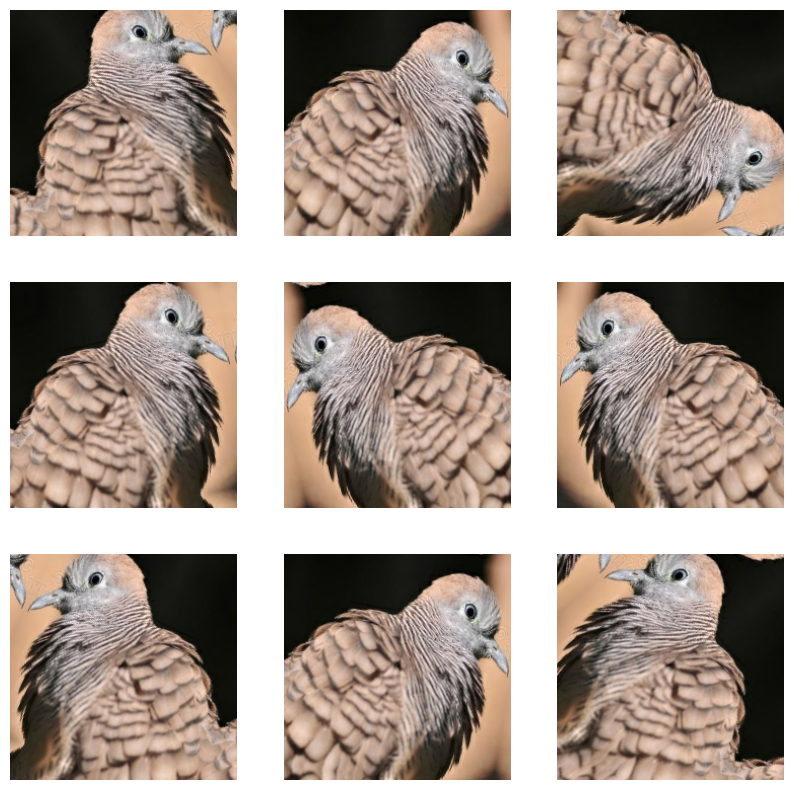

In [57]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[39]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [85]:
#rescale = tf.keras.layers.Rescaling(1./255, offset=-1)
rescale = tf.keras.layers.Rescaling(1./255)

In [86]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout , GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint


In [87]:
mobilenet = MobileNetV2( include_top=False, 
                         weights="imagenet", 
                         input_shape=(224,224,3))

In [88]:
mobilenet.build(input_shape=(None, 224, 224, 3))

In [89]:
mobilenet.trainable=False

In [90]:
for layer in mobilenet.layers[:-20]:
    layer.trainable = True


In [91]:
testmobilenet = MobileNetV2(include_top=False, 
                            weights="imagenet", 
                            input_shape=(224, 224, 3))

simple_model = Sequential([
    testmobilenet,
    GlobalAveragePooling2D(),
    Dense(450, activation='softmax')  # Ajusta '450' al número de clases en tu dataset
])

simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
simple_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 450)            │       576,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,834,434 (10.81 MB)

 Trainable params: 2,800,322 (10.68 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [92]:
simple_model2 = Sequential([
    rescale,
    testmobilenet,
    GlobalAveragePooling2D(),
    #Dense(450, activation='softmax')  # Ajusta '450' al número de clases en tu dataset,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(450, activation='softmax')
])

simple_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
simple_model2.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [93]:
def preprocess_dataset(dataset):
    return dataset.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)


In [94]:
train_dataset = preprocess_dataset(train_dataset)

In [95]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear (usualmente val_loss o val_accuracy)
    patience=10,  # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True  # Restaura los pesos del modelo a la mejor época
)


In [97]:
checkpoint_filepath = './Birds_Species_Dataset/bird_model.keras'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,  # Ruta donde guardar el modelo
    monitor='val_loss',  # Métrica a monitorear
    save_best_only=True,  # Solo guarda el modelo si es el mejor encontrado
    save_weights_only=True,  # Si solo quieres guardar los pesos, puedes poner esto en True
    mode='min'  # Modo min para val_loss, max para val_accuracy
)


In [98]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Métrica a monitorear
    factor=0.2,  # Factor por el cual se reduce la tasa de aprendizaje
    patience=5,  # Número de épocas sin mejora antes de reducir la tasa de aprendizaje
    min_lr=1e-6  # Tasa de aprendizaje mínima
)


In [99]:
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir='./logs',  # Directorio donde guardar los archivos de logs
    histogram_freq=1,  # Frecuencia (en épocas) para calcular histogramas
    write_graph=True,  # Guardar el gráfico del modelo
    write_images=True  # Guardar imágenes de los pesos
)


In [100]:
callbacks = [early_stopping, model_checkpoint, reduce_lr, tensorboard]

In [101]:
train_labels = [label for _, label in train_dataset]

non_integer_labels = [label for label in train_labels if not isinstance(label, int)]
if non_integer_labels:
    print(f"Etiquetas no enteras encontradas: {non_integer_labels[:10]}")
else:
    print("Todas las etiquetas son enteras.")

Etiquetas no enteras encontradas: [<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([170, 122, 474, 104, 350, 161, 352, 285, 162, 230, 277,  90, 383,
       123, 437, 289, 284, 161, 300, 517, 109, 263, 232, 247, 297, 375,
        48, 225, 204, 290, 515, 245, 261, 227, 291, 134, 186,  10, 333,
       241, 382, 251,  91, 503, 108, 149, 257,  80, 333, 238, 371,  80,
       131, 516, 403, 402,  58,  19, 486, 523,  40, 319,  81, 212])>, <tf.Tensor: shape=(64,), dtype=int32, numpy=
array([260, 316, 408, 324, 514, 317, 398,  63, 487, 272,  19, 237, 287,
       206, 241, 215, 258, 506, 374, 404, 428, 411, 105, 448, 400,  45,
       279, 418, 326, 175, 374, 116, 175, 429, 199,  45, 506, 405, 278,
       388, 162, 339, 500, 419, 285, 290, 310, 159, 354, 247, 175,  73,
        64, 452, 321,  38, 454,  82, 197,  86,  84, 310, 391, 166])>, <tf.Tensor: shape=(64,), dtype=int32, numpy=
array([423, 464, 169, 513, 415,  55, 107,  28, 467, 147, 216,  75, 364,
       130, 417,  37, 439, 317, 328, 497, 

In [102]:
def convert_label_to_int(label):
    try:
        return int(label)
        #return(np.vectorize(label))
    except ValueError:
        return None  # Retorna None si no se puede convertir

In [110]:
num_classes_train = len(os.listdir(train_dir))
num_classes_val = len(os.listdir(validation_dir))

print(f"Number of classes: {num_classes_train}")
print(f"Number of classes: {num_classes_val}")


Number of classes: 525
Number of classes: 525


In [103]:
import numpy as np

train_labels = [label for _, label in train_dataset]
#train_labels_corrected = [convert_label_to_int(label) for label in train_labels]
#train_labels_corrected = [label for label in train_labels_corrected if label is not None]
#test_train_labels = np.array(train_labels[0])
#print(test_train_labels)
#train_labels = np.asarray(train_labels, dtype="object")
#train_labels = np.array(train_labels_corrected, dtype="object")



In [30]:
# Verificar las etiquetas únicas y su rango
#unique_labels = np.unique(train_labels)
#print(f"Etiquetas únicas: {unique_labels}")

# Verificar si alguna etiqueta está fuera del rango [0, 449]
#if np.any(unique_labels >= 450):
#    print("Hay etiquetas fuera del rango [0, 449]:")
#    print(unique_labels[unique_labels >= 450])

In [31]:
#num_classes = len(unique_labels)
#print(num_classes)

In [113]:
MobileNetV2Model = Sequential([
    #data_augmentation,
    rescale,
    mobilenet,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Flatten(),
    #Dense(512, activation='relu'),
    #Dense(num_classes, activation='relu'),
    Dense(1024, activation='relu'),    
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes_train, activation='softmax')
])

In [114]:
MobileNetV2Model.compile( optimizer="adamax", 
                          loss="sparse_categorical_crossentropy" , 
                          metrics=["accuracy"] )

In [115]:
batch_size= 32
steps_per_epoch = len(train_dataset) // batch_size
validation_steps = len(validation_dataset) // batch_size
steps_per_epoch2 = int(len(train_dataset) * 0.5)
validation_steps2 = int(len(validation_dataset) *0.5)

steps_per_epoch3 = int(len(train_dataset) * 1)
validation_steps3 = int(len(validation_dataset) *1)

print(steps_per_epoch)
print(validation_steps)
print(steps_per_epoch2)
print(validation_steps2)
print(steps_per_epoch3)
print(validation_steps3)


41
1
661
21
1323
42


In [151]:
history = MobileNetV2Model.fit(
                               #train_dataset,
                               train_dataset.repeat(),
                               epochs=30, 
                               #epochs=4,
                               batch_size=batch_size,
                               #steps_per_epoch = len(train_dataset),
                               steps_per_epoch = steps_per_epoch*3,
                               callbacks=callbacks,
                               #workers=10, 
                               validation_data=validation_dataset.repeat(),
                               #validation_steps = len(validation_dataset)
                               validation_steps = validation_steps
                               )

Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 756s 6s/step - accuracy: 0.8722 - loss: 0.5496 - val_accuracy: 0.8281 - val_loss: 0.6352 - learning_rate: 2.0000e-04
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 751s 6s/step - accuracy: 0.8764 - loss: 0.5357 - val_accuracy: 0.8906 - val_loss: 0.5887 - learning_rate: 2.0000e-04
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 753s 6s/step - accuracy: 0.8932 - loss: 0.4754 - val_accuracy: 0.8906 - val_loss: 0.4801 - learning_rate: 2.0000e-04
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 754s 6s/step - accuracy: 0.8575 - loss: 0.6031 - val_accuracy: 0.8906 - val_loss: 0.5202 - learning_rate: 2.0000e-04
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 756s 6s/step - accuracy: 0.8644 - loss: 0.5861 - val_accuracy: 0.8906 - val_loss: 0.4645 - learning_rate: 2.0000e-04
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 757s 6s/step - accuracy: 0.8398 - loss: 0.6675 - val_accuracy: 0.9531 - val_loss: 0.2268 - learning_rate: 2.0000e-04
Epoch 7/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 755s 6s/step - acc

In [152]:
history

In [153]:
def plot_curves():

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

      #plot loss
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

      #plot accuracy
    plt.figure() 
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()
    plt.tight_layout()

In [163]:
def plot_curves():
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    # Encuentra la longitud mínima
    min_epochs = min(len(loss), len(val_loss), len(accuracy), len(val_accuracy))
    epochs = range(min_epochs)

    # Reducir los datos para que todos tengan la misma longitud
    loss = loss[:min_epochs]
    val_loss = val_loss[:min_epochs]
    accuracy = accuracy[:min_epochs]
    val_accuracy = val_accuracy[:min_epochs]

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.figure() 
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.show()
    plt.tight_layout()


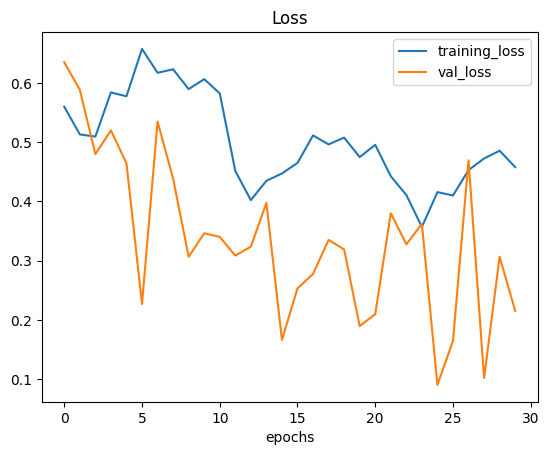

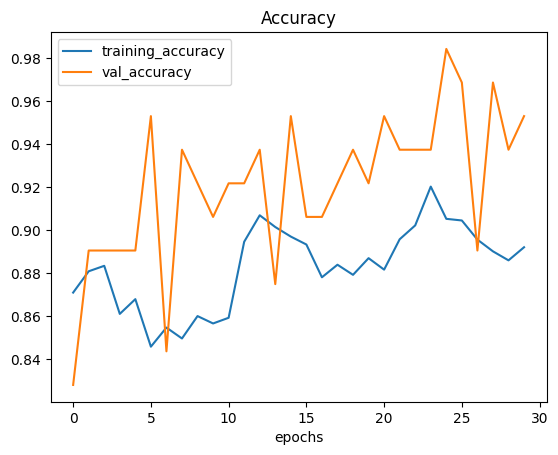

<Figure size 640x480 with 0 Axes>

In [164]:
plot_curves()

In [165]:
import urllib
from PIL import Image

In [166]:
def get_img_path(label):
    data=pd.read_csv("./Birds_Species_Dataset/birds.csv")
    return data[data.labels==label].filepaths.values[0]

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+1, y[i], ha = 'center')

In [167]:
#extracting all labels
labels = list(pd.read_csv("./Birds_Species_Dataset/birds.csv")['labels'].unique())

In [168]:
labels

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'AFRICAN PYGMY GOOSE',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMERICAN ROBIN',
 'AMERICAN WIGEON',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY STORM PETREL',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'ASIAN DOLLARD BIRD',
 'ASIAN GREEN BEE EATER',
 'ASIAN OPENBILL STORK',
 'AUCKLAND SHAQ',
 'AUSTRAL CANASTERO',
 'AUSTRALASIAN FIGBIRD',
 'AVADAVAT',
 'AZARAS SPINETAIL',
 'AZURE BREASTED PITTA',
 'A

In [169]:
model = tf.keras.models.load_model('./Birds_Species_Dataset/bird_model.keras')
#model = tf.keras.models.load_model('./Birds_Species_Dataset/Test_original_model.h5')

In [170]:
def bird_pred1(url):
    img=urllib.request.urlretrieve(url,"img.png")
    img=Image.open("img.png")
    img=img.resize((224,224))
    img_arr=np.array(img)
    pred=model.predict(np.expand_dims(img_arr,0))
    top_img=np.argmax(pred)
    top_5=np.argsort(pred)[:,-5:]
    pred=pred.reshape((450,))
    top_5=top_5.reshape((5,))
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    plt.title("Result")
    x=np.flip([labels[x] for x in top_5])
    y=np.flip([round(pred[x]*100,2) for x in top_5])
    plt.bar(x, y)
    plt.xticks(rotation=90)
    addlabels(x, y)
    plt.yticks()
    plt.subplot(1,3,2)
    plt.title(labels[top_img])
    img_read=Image.open(os.path.join("./Birds_Species_Dataset/",get_img_path(labels[top_img])))
    plt.imshow(np.array(img_read))
    plt.subplot(1,3,3)
    plt.title("Uploaded Image")
    plt.imshow(img_arr)
    plt.show()

In [171]:
def bird_pred(url):
    try:
        # Descargar la imagen
        img_path, _ = urllib.request.urlretrieve(url, "img.png")
        img = Image.open(img_path).convert("RGB")
        img = img.resize((224, 224))
        
        # Convertir la imagen a array
        img_arr = np.array(img)
        
        # Verificar el formato de la imagen
        if img_arr.shape != (224, 224, 3):
            print(f"Error: Image shape is {img_arr.shape}, expected (224, 224, 3)")
            return
        
        # Realizar la predicción
        pred = model.predict(np.expand_dims(img_arr, 0))
        print(f"Shape of pred: {pred.shape}")  # Verificar la forma de la predicción
        
        # Aplanar pred si es necesario
        pred = pred.flatten()  # Aplanar el array
        
        top_img = np.argmax(pred)
        top_5 = np.argsort(pred)[-5:]
        
        # Gráfico de barras de predicción
        plt.figure(figsize=(14,4))
        plt.subplot(1,3,1)
        plt.title("Result")
        x = np.flip([labels[x] for x in top_5])
        y = np.flip([round(pred[x]*100, 2) for x in top_5])
        plt.bar(x, y)
        plt.xticks(rotation=90)
        addlabels(x, y)
        plt.yticks()
        
        # Imagen de referencia
        plt.subplot(1,3,2)
        plt.title(labels[top_img])
        try:
            img_read = Image.open(os.path.join("./Birds_Species_Dataset/", get_img_path(labels[top_img])))
            plt.imshow(np.array(img_read))
        except Exception as e:
            print(f"Error opening reference image: {e}")
        
        # Imagen cargada
        plt.subplot(1,3,3)
        plt.title("Uploaded Image")
        plt.imshow(img_arr)
        plt.show()
    
    except Exception as e:
        print(f"Error: {e}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Shape of pred: (1, 525)


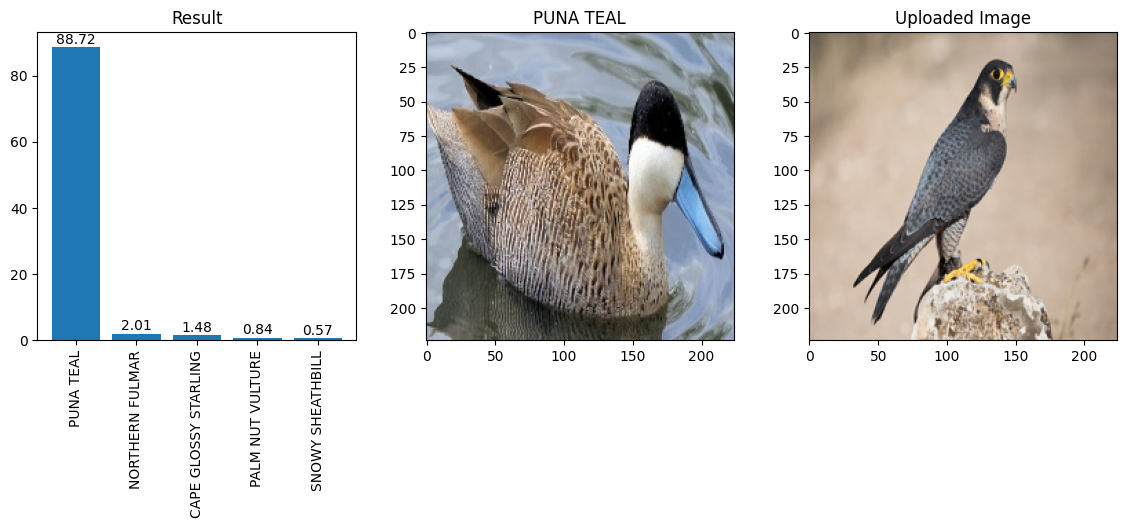

In [172]:
#bird_pred("https://cdn.britannica.com/09/157809-050-073D23F3/Indian-bustard-bird-species.jpg")
bird_pred("https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Falco_peregrinus_-_01.jpg/1280px-Falco_peregrinus_-_01.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Shape of pred: (1, 525)


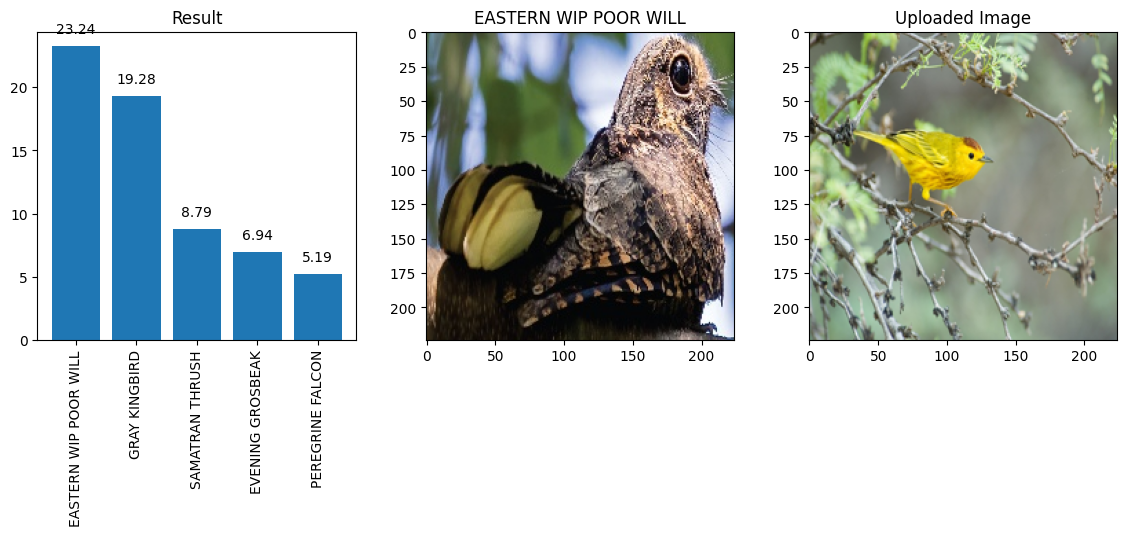

In [173]:
bird_pred('https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Dendroica_petechia_2446949099.jpg/1280px-Dendroica_petechia_2446949099.jpg')